# Unsupervised Learning

Unsupervised learning techniques are used to find hidden patterns in data, such as distinct groups of patients with different characteristics without relying on labels. Methods such as Principal Component Analysis (PCA) and K-Means clustering are some examples of this.

In this example, we will use PCA for dimensionality reduction and to determine new key features that are derived from the existing continuous features such as age, creatinine etc. We will also use K-Means to perform clustering on the dataset look at the resulting cluster characteristics. 


The datasets in this notebook can be obtained from the **UCI Machine Learning Repository**

1. Chronic Kidney Disease Dataset: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

**References**:

1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [4]:
# local_path='C:\\_Work_Folder\\SMU\\MITB_HealthcareAnalytics\\Lectures\\Datasets\\Lecture 4\\CKD\\'
ckd=pd.read_csv('https://raw.githubusercontent.com/ISSS623-AHA/Lecture---Hands-on-Codes/main/Lecture%202/chronic_kidney_disease_full.csv')

## 1 Data Scaling & Categorical Variables for Clustering

**Categorical Variables**

For most clustering methods, categorical variables are an issue as they cannot be directly used with these methods. Clustering methods often use a distance-based measure to measure the distance, or difference between two cases or a cluster center, which might be applicable for continuous variables such as sodium levels. However for categorical variables, they can only take on a discrete or fixed value such as 0 or 1, or a list of conditions and may not have an inherent ranking among them. Hence, simply calculating the distance between an integer representation such as 1,2,3,4... does not represent the contribution from this variable appropriately.

**Data Scaling**

In the CKD dataset, certain variables such as **wbcc** have a much higher value than the other variables. Although this is a continuous variable, the large values may have a much higher influence on the total variance of the dataset. This in turn affects the use of PCA, which determines the contribution of the component to the total variance as well as K-Means, which relies on the distance between data points. Hence, the dataset needs to be normalized, or scaled to a standard range before performing PCA or K-Means clustering.

- **age** - age
- **bp** - blood pressure
- **sg** - specific gravity
- **al** - albumin
- **su** - sugar
- **rbc** - red blood cells
- **pc** - pus cell
- **pcc** - pus cell clumps
- **ba** - bacteria
- **bgr** - blood glucose random
- **bu** - blood urea
- **sc** - serum creatinine
- **sod** - sodium
- **pot** - potassium
- **hemo** - hemoglobin
- **pcv** - packed cell volume
- **wc** - white blood cell count
- **rc** - red blood cell count
- **htn** - hypertension
- **dm** - diabetes mellitus
- **cad** - coronary artery disease
- **appet** - appetite
- **pe** - pedal edema
- **ane** - anemia
- [target] **class** - class

In [ ]:
ckd[ckd.duplicated(subset=None)]

In [ ]:
ckd.replace('?',np.nan,inplace=True)

In [ ]:
# too many na's -> cannot drop. To deal with it using imputation
print(len(ckd))
ckd_na = ckd.dropna(how='any')
print(len(ckd_na))

In [ ]:
# From Lecture 2 Data Wrangling, we have the following groups of fields
categorical_cols = ['rbc','pc','pcc','ba','appet']
boolean_cols=['htn','dm','cad','pe','ane']
numeric_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
target = ['class']

In [ ]:
# Correcting all the data types in ckd_new
ckd_new = ckd
ckd_new[numeric_cols]=ckd_new[numeric_cols].astype('float')

In [ ]:
for col in categorical_cols:
    one_hot = pd.get_dummies(ckd_new[col],drop_first=True,dummy_na=True)
    one_hot.columns = [col + '_' + str(a) for a in one_hot.columns]
    ckd_new = ckd_new.drop(col,axis=1)
    ckd_new = ckd_new.join(one_hot)

In [ ]:
# Label encoding for Boolean variables ('Yes' -> True; 'No' -> False)
ckd_new[boolean_cols] = np.where(ckd_new[boolean_cols] == 'Yes',True,False)
ckd_new[boolean_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   htn     400 non-null    bool 
 1   dm      400 non-null    bool 
 2   cad     400 non-null    bool 
 3   pe      400 non-null    bool 
 4   ane     400 non-null    bool 
dtypes: bool(5)
memory usage: 2.1 KB


In [ ]:

ckd_new[target]=np.where(ckd_new[target]=='ckd',1,0)

In [ ]:
ckd_new.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,pe,ane,class,rbc_normal,rbc_nan,pc_normal,pc_nan,pcc_present,pcc_nan,ba_present,ba_nan,appet_poor,appet_nan
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,False,False,False,False,False,1,0,1,1,0,0,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,False,False,False,False,False,1,0,1,1,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,False,False,False,False,False,1,1,0,1,0,0,0,0,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,False,False,False,False,False,1,1,0,0,0,1,0,0,0,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,False,False,False,False,False,1,1,0,1,0,0,0,0,0,0,0


In [ ]:
ckd_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          391 non-null    float64
 1   bp           388 non-null    float64
 2   sg           353 non-null    float64
 3   al           354 non-null    float64
 4   su           351 non-null    float64
 5   bgr          356 non-null    float64
 6   bu           381 non-null    float64
 7   sc           383 non-null    float64
 8   sod          313 non-null    float64
 9   pot          312 non-null    float64
 10  hemo         348 non-null    float64
 11  pcv          329 non-null    float64
 12  wbcc         294 non-null    float64
 13  rbcc         269 non-null    float64
 14  htn          400 non-null    bool   
 15  dm           400 non-null    bool   
 16  cad          400 non-null    bool   
 17  pe           400 non-null    bool   
 18  ane          400 non-null    bool   
 19  class   

In [ ]:
print('Samples with CKD = {0}\nSamples with NO CKD = {1} '.format(ckd_new[ckd_new['class']==1].shape[0],ckd_new[ckd_new['class']==0].shape[0]))

Samples with CKD = 250
Samples with NO CKD = 150 


In [ ]:
from pandas_profiling import ProfileReport
file = ProfileReport(ckd_new)
file.to_notebook_iframe()

## 2.2 Handling Missing Values

CKD numeric columns have NaN which PCA cannot deal with. One way is to impute these null values without biasing the algorithm.

A common way to handle cases with missing values is to exclude them from the analysis, however if the initial dataset size is small, it may not be a good option as this further reduces the number of examples that can be used. 

In this case, one might be able to consider **imputation**, which are methods to help to fill in these missing values through statistical means. A simple method for numeric columns is to replace such missing values with the mean or median value of all of the available values for that variable. This can be done in `sklearn` using the `SimpleImputer` class.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(ckd_new[numeric_cols])
ckd_new[numeric_cols] = imp.transform(ckd_new[numeric_cols])
ckd_new[numeric_cols] = ckd_new[numeric_cols].astype(np.float32)

## 2.3 Rescaling of numeric columns

In [ ]:
ckd_num = ckd_new[numeric_cols]
ckd_std = StandardScaler().fit_transform(ckd_num)


## 2 Principal Component Analysis (PCA)

For some datasets, there may be large number of observations and factors that are hard to visualize and explain in terms of factors. Principal components (PCs) are composite variables that are combinations of the original variables e.g. rbc, pc, pcc, ba etc that can be used to represent the original variables without losing too much information. You can think of these PCs as a new variable that represents a few of those variables. In this example, we will perform PCA on the numeric variables of the CKD dataset and see if these variables can be represented by a smaller set of factors or PCs. 

This is done using the ``PCA()`` object from ``sklearn.decomposition``.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(ckd_std)
X_pca.shape

(400, 14)

### Scree Plot for PCA

As the objective of PCA is to reduce the number of factors to be used in the dataset, a key step is determine the number of components or PCs to be used. This can be done by plotting the total variance that each PC represents in the dataset and sorting them in descending order. Plot the bar chart using the code below. How many PCs do you think will be sufficient?

Text(0.5, 0, 'Principal Component')

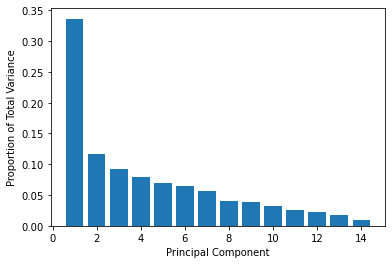

In [ ]:
%matplotlib inline
plt.bar(range(1,X_pca.shape[1]+1),pca.explained_variance_ratio_)
plt.ylabel('Proportion of Total Variance')
plt.xlabel('Principal Component')

In [ ]:
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]

### Visualization for 2 PCs

Based on the scree plot, 2 or 3 PCs will account for a reasonable proportion of total variations. Let's plot the cases according to these PCs and label them with their original labels (No CKD or CKD) and see if there are any patterns or clusters. Plot the scatterplot using the code below. What do you notice about the plotted points?

In [ ]:
y = ckd_new['class']

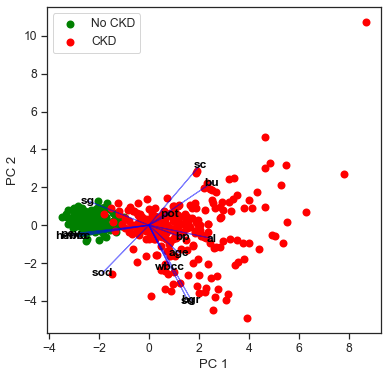

In [ ]:
%matplotlib inline
# Visualize using PCA for labelled data
colors = ['green', 'red']
labels = ['No CKD','CKD']
plt.figure(figsize=(6, 6))
for color, i, target_name in zip(colors, [0, 1], [0,1]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                color=color, lw=2, label=labels[target_name])
plt.legend(loc="best", shadow=False, scatterpoints=1)
for i in range(n):
    plt.arrow(0, 0, coeff[i,0]*8, coeff[i,1]*8,color = 'b',alpha = 0.5)
    plt.text(coeff[i,0]* 8, coeff[i,1] * 8, numeric_cols[i], color = 'black', ha = 'center', va = 'center',fontsize='large',fontweight='bold')
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### Visualization for 3 PCs

As the scree plot indicates above, 3 PCs are also a reasonable number of PCs that can be used to represent these variables in the dataset. This can be visualized through a 3D scatterplot here. Do you see anything different from the 2D plot for 2 PCs?

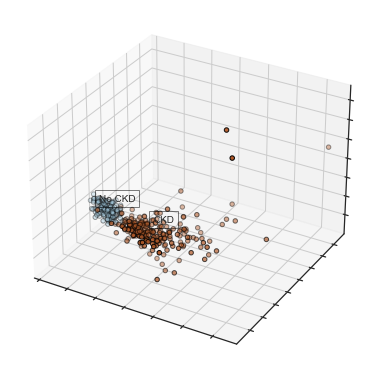

In [ ]:
# %matplotlib notebook
fig = plt.figure(1, figsize=(5, 5))
plt.clf()
ax = Axes3D(fig)

plt.cla()

for name, label in [('No CKD', 0), ('CKD', 1)]:
    ax.text3D(X_pca[y == label, 0].mean(),
              X_pca[y == label, 1].mean() + 1.5,
              X_pca[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='black', facecolor='none'))
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='Paired',
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

## 3 K-Means Clustering

K-Means clustering is an iterative algorithm that aims to find *k* number of cluster centers, given the variables in the input dataset. As this is an unsupervised learning method, no labels are required and the goal is to find patterns or natural clusters in the dataset. The algorithm starts by randomly initializing a given number of cluster centers, and iteratively updates these center positions according to the intra-cluster and inter-cluster distances between the cases and other cluster centers respectively. The ``KMeans()`` object from ``sklearn.cluster`` can be used to perform K-Means clustering on the CKD dataset.

In [ ]:
kmeans = KMeans(n_clusters=2).fit(ckd_std)
ckd_num['cluster'] = kmeans.labels_

<ipython-input-29-d1bbc5c511a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ckd_num['cluster'] = kmeans.labels_


In [ ]:
kmeans.cluster_centers_

array([[-0.41161987, -0.36100295,  0.6330001 , -0.59684795, -0.38179228,
        -0.44051793, -0.48678353, -0.33772245,  0.3425967 , -0.10555359,
         0.7369189 ,  0.7209508 , -0.22449386,  0.6026217 ],
       [ 0.40346888,  0.35385427, -0.62046605,  0.5850301 ,  0.3742312 ,
         0.43179482,  0.47714418,  0.33103478, -0.3358124 ,  0.10346352,
        -0.72232664, -0.70667416,  0.22004855, -0.5906886 ]],
      dtype=float32)

### Number of Clusters

In K-Means clustering, a key parameter is the number of initial clusters to use and can be determined using the inertia or within-cluster sum-of-squares. By plotting the inertia over different number of clusters, the optimal number of clusters can be determined by looking at the changes in inertia between each number of clusters. This is known as the **elbow method**, where a point is preceded by a large drop in inertia and followed by gradual decrease in inertia.

Run the code below to plot the inertia values over varying numbers of clusters and observe the points. What would be a suitable number of clusters to use?

c:\Users\Sean Lam\.conda\envs\snowflakes\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


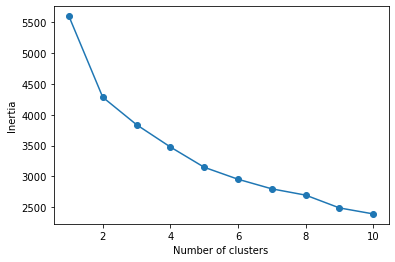

In [ ]:
%matplotlib inline
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random',random_state=0)
    kmeans.fit(ckd_std)
    inertias.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
inertias

[5599.99853515625,
 4285.5966796875,
 3838.94775390625,
 3477.04248046875,
 3147.865966796875,
 2953.33203125,
 2797.287109375,
 2695.462890625,
 2487.5146484375,
 2390.296630859375]

### Visualizing Clusters with PCA

Once a suitable number of clusters has been determined, perform the K-Means clustering on the scaled dataset with the specified number of clusters. However, unlike PCA, it is difficult to visualize the clusters across all possible features. Another way of is to use the PCs that have been generated from the PCA step as features that can be used for clustering.

Fit the model using the `KMeans` method below and run the following code to plot the cluster labels across the PCs. What do you observe about the pattern between these two clusters and the earlier PC plot?

In [ ]:
pca_df = pd.DataFrame(X_pca)

In [ ]:
kmeans = KMeans(n_clusters=2).fit(pca_df[[0,1]])
pca_df['cluster'] = kmeans.labels_
ckd['cluster'] = kmeans.labels_
centers = kmeans.cluster_centers_
# ckd_num['c']

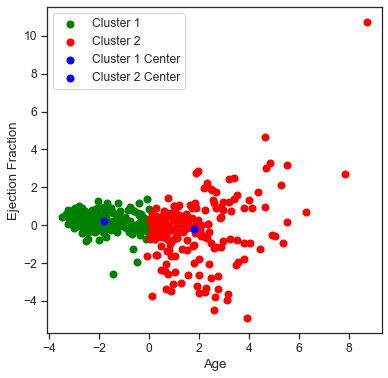

In [ ]:
# Visualizing with PCA for clustered data without labels (Unsupervised Learning)
%matplotlib inline
colors = ['green', 'red']
clusters = ['Cluster 1','Cluster 2']
plt.figure(figsize=(6, 6))
for color, i, target_name in zip(colors, [0, 1], [0,1]):
    plt.scatter(pca_df[pca_df['cluster'] == i][0], pca_df[pca_df['cluster'] == i][1],
                color=color, lw=2, label=clusters[target_name])
plt.scatter(centers[0][0], centers[0][1],
                color='blue', lw=2, label='Cluster 1 Center')
plt.scatter(centers[1][0], centers[1][1],
                color='blue', lw=2, label='Cluster 2 Center')
plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('Age')
plt.ylabel('Ejection Fraction')
plt.show()

### Examine Cluster Characteristics

An alternative way to examine the cluster characteristics is to compare the summary statistics of the cases in each cluster. Run the descriptive summary for each cluster below and observe the statistics over the features. Are there any difference between the two clusters? What other methods would you use to compare the distribution of each feature?

In [ ]:
ckd[ckd['cluster'] == 0].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,cluster
count,198.000000,194.000000,188.000000,189.000000,188.000000,183.000000,192.000000,192.000000,173.000000,173.000000,176.000000,174.000000,165.000000,156.000000,200.0
mean,44.767677,72.010309,1.020957,0.211640,0.031915,111.595628,32.179688,1.097396,141.144509,4.280925,14.777841,45.563218,7715.757576,5.349359,0.0
std,17.400232,10.360342,0.004057,0.720278,0.308598,28.199454,13.642989,1.060743,4.850909,0.592232,1.615326,4.709359,1956.382660,0.611027,0.0
min,4.000000,50.000000,1.010000,0.000000,0.000000,22.000000,1.500000,0.400000,127.000000,2.800000,8.100000,33.000000,2200.000000,3.800000,0.0
25%,33.000000,60.000000,1.020000,0.000000,0.000000,94.000000,20.750000,0.700000,138.000000,3.700000,13.700000,42.000000,6300.000000,4.900000,0.0
50%,46.000000,70.000000,1.020000,0.000000,0.000000,109.000000,30.000000,0.900000,141.000000,4.300000,15.000000,45.000000,7500.000000,5.300000,0.0
75%,58.000000,80.000000,1.025000,0.000000,0.000000,125.000000,44.000000,1.200000,145.000000,4.900000,15.900000,50.000000,9300.000000,5.825000,0.0
max,80.000000,120.000000,1.025000,4.000000,4.000000,250.000000,106.000000,11.500000,150.000000,5.300000,17.800000,54.000000,12500.000000,6.500000,0.0


In [ ]:
ckd[ckd['cluster'] == 1].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,cluster
count,193.000000,194.000000,165.000000,165.000000,163.000000,173.000000,189.000000,191.000000,140.000000,139.000000,172.000000,155.000000,129.000000,113.000000,200.0
mean,58.373057,80.927835,1.013364,1.939394,0.932515,186.583815,83.072487,5.057853,133.060714,5.058273,10.222674,31.387097,9289.147287,3.821239,1.0
std,13.925984,15.104642,0.004525,1.319169,1.436426,96.043354,60.449107,7.565212,13.329994,4.713239,1.997164,6.344429,3679.933770,0.795349,0.0
min,2.000000,50.000000,1.005000,0.000000,0.000000,70.000000,16.000000,0.500000,4.500000,2.500000,3.100000,9.000000,2600.000000,2.100000,1.0
25%,50.000000,70.000000,1.010000,1.000000,0.000000,111.000000,40.000000,1.700000,131.000000,3.900000,9.100000,28.000000,6900.000000,3.400000,1.0
50%,60.000000,80.000000,1.015000,2.000000,0.000000,158.000000,65.000000,2.800000,135.000000,4.400000,10.300000,32.000000,9200.000000,3.800000,1.0
75%,68.000000,90.000000,1.015000,3.000000,2.000000,239.000000,106.000000,5.750000,139.000000,5.050000,11.525000,36.000000,10700.000000,4.300000,1.0
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,15.200000,44.000000,26400.000000,8.000000,1.0


### t-SNE visualization of clusters

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. 

1.  Step 1, measure similarities between points in the high dimensional space. For each data point (xi) we’ll center a Gaussian distribution over that point. Then we measure the density of all points (xj) under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities (Pij) for all points. Those probabilities are proportional to the similarities. 
2.  Step 2 is similar to step 1, but instead of using a Gaussian distribution you use a Student t-distribution with one degree of freedom, which is also known as the Cauchy distribution 
3.  Step 3, Map these set of probabilities from the low-dimensional space (Qij) to reflect those of the high dimensional space (Pij) as best as possible. 

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(ckd_num) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.002s...
[t-SNE] Computed neighbors for 400 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 12.058891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.416508
[t-SNE] KL divergence after 1000 iterations: 0.194776


In [ ]:
df_tsne=pd.DataFrame(ckd_new['class'])
df_tsne['TSNE Component 1']=z[:,0].copy()
df_tsne['TSNE Component 2']=z[:,1].copy()

[Text(0.5, 1.0, 'CKD data T-SNE projection')]

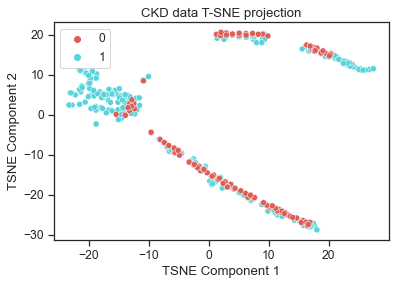

In [ ]:
# plotting CKD vs non CKD as colour coded above the clusters generated
sns.scatterplot(x="TSNE Component 1", y="TSNE Component 2", hue=df_tsne['class'].tolist(), palette=sns.color_palette("hls", 2),
                data=df_tsne).set(title="CKD data T-SNE projection")

